In [5]:
#TODO
# - fazer analise com funções quadraticas simples
# - fazer analise com funções quadraticas criadas aleatoriamente
#     - criar função para gerar quadraticas convexas e nao convexas aleatoriamente (strongly convex é facil)
# - fazer calculo do gradiente da softmax
# - 

# Bibliotecas a serem usados no projeto

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

2024-11-21 14:58:55.047268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732211935.097602   10791 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732211935.110916   10791 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 14:58:55.222519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Parte 1: gradiente descendente em funções quadráticas

Ao implementar um algoritmo de descida de gradiente, podemos escolher dentre diversos métodos para escolha do tamanho do passo a ser dado. Aqui, exploraremos dois deles: short-step e busca em linha exata.

## Preparação das funções quadráticas

Sabemos que para funções diferenciáveis, uma possível definição de convexidade forte é se a função pode ser cotada inferiormente por uma quadrática de coefficiente $m>0$. Em outras palavras, temos:

$$f(y) \geq f(x)+\nabla f(x)^T(y-x)+\frac{m}{2}\|y-x\|^2 \hspace{10pt} \forall x,y \in \text{Dom}(f)$$

Além disso, se a função é duplamente continuamente diferenciável - o que seria o caso neste exercício, já que lidamos apenas com quadráticas - uma outra maneira de caracterizar convexidade forte é pela propriedade

$$ \nabla^2 f(x) \succeq mI  \implies Q - mI \succeq 0. $$

Logo, teremos que definir $Q$ de tal modo que possua paenas autovalores positivos para os casos fortemente convexos, e pelo menos um autovalor nulo para o caso convexo. A função não convexa por sua vez possuirá pelo menos um autovalor negativo.

In [ ]:
def BuildQuadratic(n:int=2, convexity:str='stronglyConvex', seed:int=0):

    Q = np.zeros((n,n))
    b = np.zeros(n)



    match convexity:
        case 'stronglyConvex':
            pass
        case 'convex':
            pass
        case 'nonConvex':
            pass


def StronglyConvexQuadratic(x:np.array):

    Q = np.array([[2, 1],[1, 3]])
    Q = Q.T @ Q

    b = np.array([0,0])

    c = 0

    return x.T @ Q @ x + b.T @ x + c

def ConvexQuadratic(x:np.array):

    Q = np.array([[2, 1],[8, 4]])

    b = np.array([0,0])

    c = 0

    return x.T @ Q @ x + b.T @ x + c

def NonConvexQuadratic(x:np.array):

    Q = np.array([[2, 1],[8, 4]])

    b = np.array([0,0])

    c = 0

    return x.T @ Q @ x + b.T @ x + c

def discretizedFunction(x0:np.ndarray, x1:np.ndarray, function:callable):
    functionValues = np.zeros((x0.size, x1.size))
    for i in range(x0.size):
        for j in range(x1.size):
            functionValues[j, i] = function(np.array([x0[i], x1[j]]))
    return functionValues

In [20]:
Q = np.array([[2, 1],[8, 4]])
eigvalues, eigvectors = np.linalg.eig(Q)
print(eigvalues)



[0. 6.]


## Plot e análises das funções

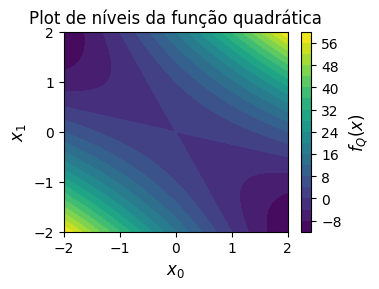

In [19]:
# Calculando valores das funções 
x0 = np.linspace(-2, 2, 1000)
x1 = np.linspace(-2, 2, 1000)

functionValuesQ = discretizedFunction(x0, x1, ConvexQuadratic)

# Criando plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

# Plot da função quadrática
contour1 = ax1.contourf(x0, x1, functionValuesQ, levels=20, cmap='viridis')
colorBar1 = fig.colorbar(contour1, ax=ax1)
colorBar1.set_label(label='$f_Q(x)$', fontsize=12)
ax1.set_xlabel('$x_0$', fontsize=12)
ax1.set_ylabel('$x_1$', fontsize=12)
ax1.set_title('Plot de níveis da função quadrática', fontsize=12)
ax1.axis('tight')


plt.tight_layout()
plt.show()

## Gradiente descendente com busca em linha exata

## Gradiente descendente com short-step

# Parte 2: classificação multinomial no dataset MNIST

## Cáculo do gradiente da função objetivo da softmax regression

A função custo para a regressão logística multinomial é dada por

$$ J(\theta) = -\left[ \sum_{i=1}^{m}\sum_{k=1}^{K} \delta(y^i=k) \log \left( \frac{\exp ({\theta^k}^Tx^i)}{\sum_{j=1}^{K}\exp({\theta^j}^Tx^i)} \right) \right], $$


e seu gradiente por sua vez é

$$ \nabla_{\theta^k}J(\theta) = -\sum_{i=1}^{m} \left[ x^i (\delta (y^i=k) - \frac{\exp ({\theta^k}^Tx^i)}{\sum_{j=1}^{K}\exp({\theta^j}^Tx^i)} ) \right] $$ 


## Carregando base de dados MNIST e preparando conjuntos de treino/teste

In [ ]:
# Load the MNIST dataset
(mnist_train, mnist_test) = tf.keras.datasets.mnist.load_data()

# Separate features and labels for training and testing
(x_train, y_train) = mnist_train
(x_test, y_test) = mnist_test

# Normalize the images to [0, 1] range
x_train, x_test = x_train / 255.0, x_test / 255.0